In this notebook we will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), the convolutional neural network architecture that helped start the current interest in deep learning. We will move on to the CIFAR10 dataset - 32x32 color images in ten classes. 

### Something to remember:


*   Relu
*   Dropout
*   Overlap pooling to reduce the size of network



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [ ]:
os.chdir('/content/drive/MyDrive/ML-LAB/Code/ComVis')

## Data Processing

In [ ]:
# To make the results reproducible
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)


means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Why we divide data by 255 to calculate mean and std?


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

RGB (Red, Green, Blue) are 8 bit each.
The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
The combination range is 256*256*256.

By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).

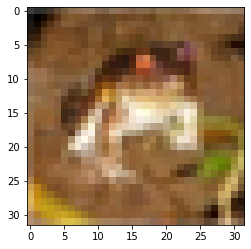

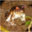

In [ ]:
plt.imshow(next(iter(train_data[0])))
plt.show()
next(iter(train_data[0]))

Next up is defining the transforms for data augmentation.

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

why in test transform we are using the mean and std from train data?


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

We use the average and sd of the train because the network will been trained with those values and we assume that the train is big enough to represent even test images.

In [ ]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_data.data.shape)
print(test_data.data.shape)
print(set(train_data.targets))
print(train_data.classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


What does **3** represent?


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

RGB, so the number of channel!

Now let's create a validation set from our training set



In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

# let ensure our valid_data have the same transform as test ( so only normalization )

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
print('Number of training examples:', len(train_data))
print('Number of validation examples:',len(valid_data))
print('Number of testing examples: ', len(test_data))

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples:  10000


Now, we'll create a function to plot some images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged [channel, height, width], but matplotlib expects images to be [height, width, channel], hence we need to permute our images before plotting them.

In [ ]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes


Let's have a look on the picture dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

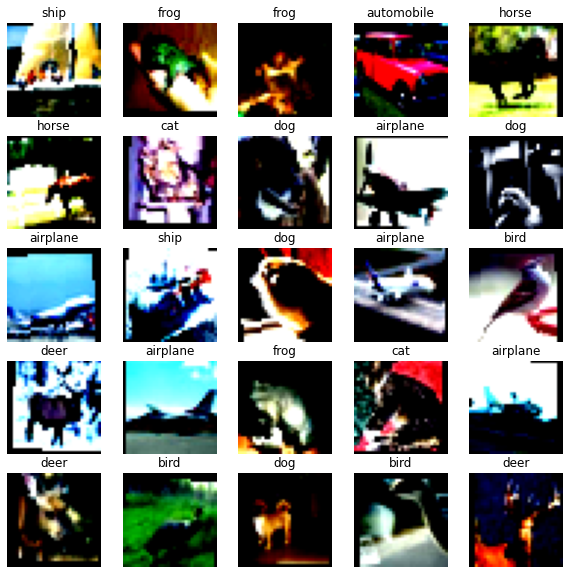

In [ ]:
# No normalization
plot_images(images, labels, classes, normalize = False)

When we plot them we see lots of warnings. This is because matplotlib is expecting the values of every pixel to be between [0,1] , however our normalization will cause them to be outside this range. By default matplotlib will then clip these values into the  range [0,1]. This clipping causes all the images to look a bit weird - all the colors are oversaturated.

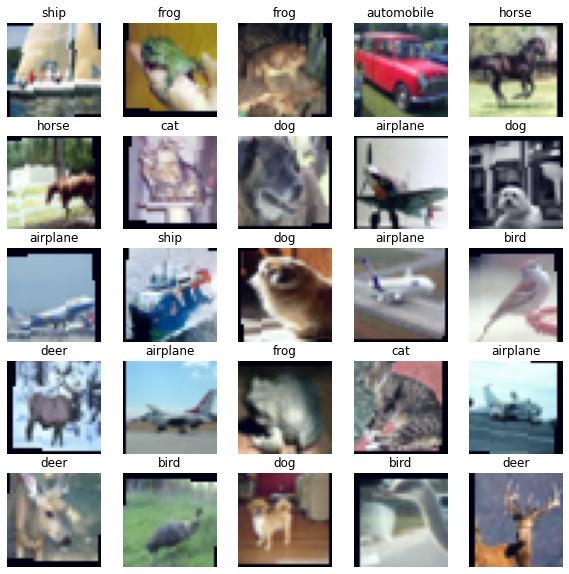

In [ ]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

We'll check what images look like with Sobel filters applied to them.

In [ ]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the plot_filter function.

Below is a filter which detects horizontal lines.

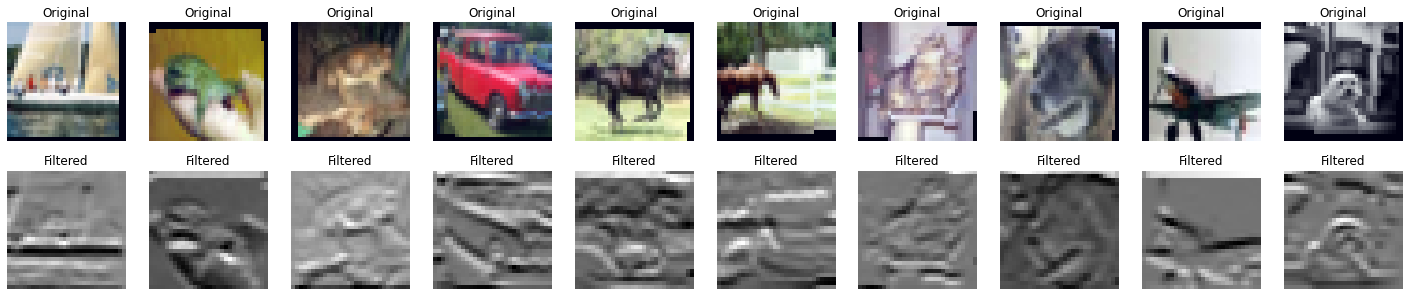

In [ ]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Here's a filter that detects vertical lines.

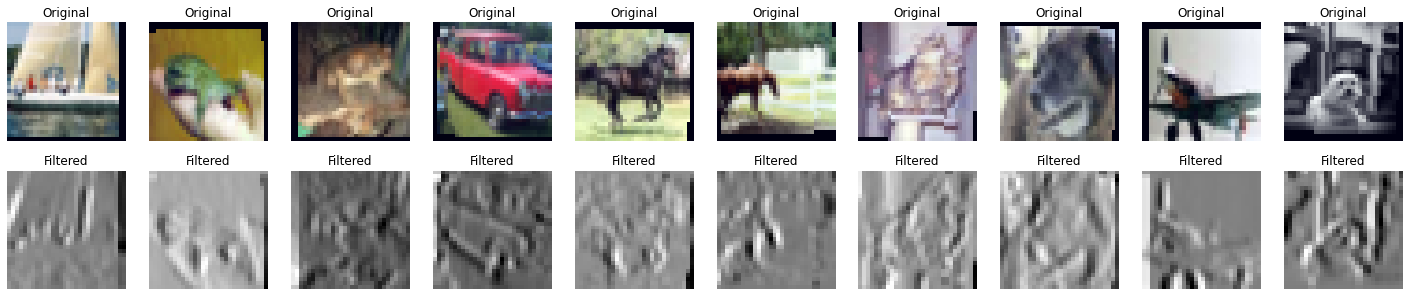

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

We'll also do the same for subsampling/pooling.

In [ ]:
def plot_subsample(images, pool_type, pool_size, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Subsampled')
        ax.axis('off')

The higher filter sizes in the pooling layers means more information is lost, i.e. the image becomes lower resolution.

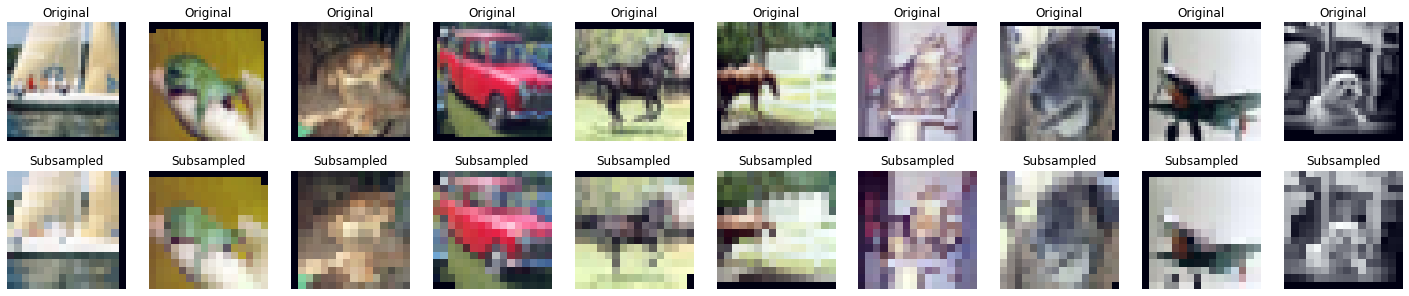

In [ ]:
plot_subsample(images, 'max', 2) # cosa accade con questo pooling? -> Immagine si riduce - > meno pixel

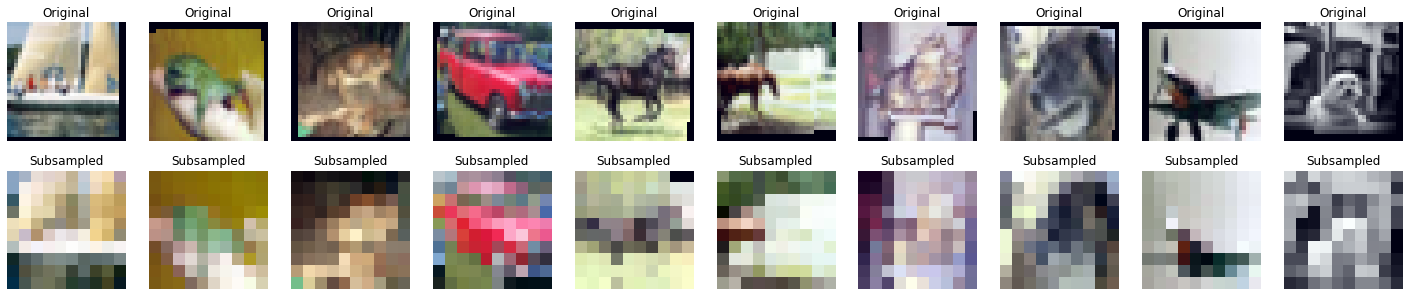

In [ ]:
plot_subsample(images, 'max', 3)

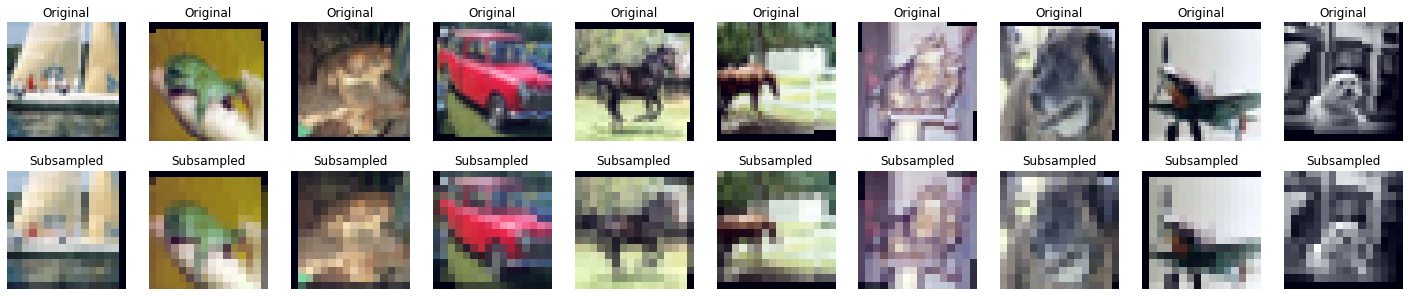

In [ ]:
plot_subsample(images, 'avg', 2)

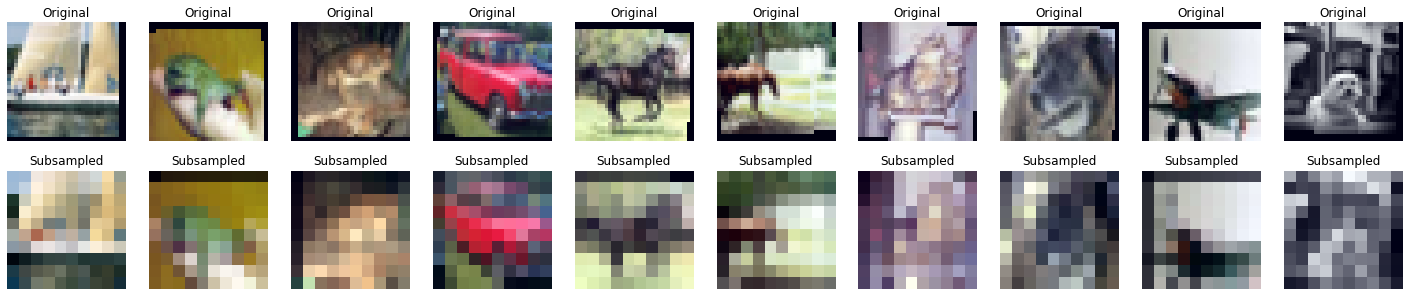

In [ ]:
plot_subsample(images, 'avg', 3)

The final bit of the data processing is creating the iterators.


We are gonna use a batch size of 256 for trains our model faster

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the model

### Some remarks:
LeNet is made up of convolutional layers, pooling layers and ReLU activation functions.
During the convolutional and pooling layers the activation function should be placed after the pooling layer to reduce computational cost.
The very first convolutional layer has an in_channel of three. That is because we are handling color images that have three channels RBG (instead of the single channel grayscale images from the MNIST dataset). This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1), #padding per non far ridurre l'immagine
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

We'll create an instance of our model with the desired amount of classes.

In [ ]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

AlexNet is a relatively small model for computer vision

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


## Training Model

PyTorch's default initialization is usually fine however by manually trying different initialization schemes we can usually squeeze out a slight performance improvement.

We initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the nn.init methods to actually initialize the parameters.

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu') #initialize weight
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's apply method. This will call the given function on every module and sub-module within the model.

In [ ]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in



The most commonly used optimizer used is Adam. 




&nbsp;

&nbsp;

What does the optimiser do? And what is the learning rate?

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss() #multi-class classification 
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally training time!

In [ ]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_alex_1.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 2.504 | Train Acc: 17.07%
	 Val. Loss: 1.736 |  Val. Acc: 32.50%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 1.621 | Train Acc: 39.04%
	 Val. Loss: 1.420 |  Val. Acc: 48.17%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 1.404 | Train Acc: 49.04%
	 Val. Loss: 1.280 |  Val. Acc: 53.85%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 1.277 | Train Acc: 54.19%
	 Val. Loss: 1.158 |  Val. Acc: 59.25%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 1.196 | Train Acc: 57.22%
	 Val. Loss: 1.116 |  Val. Acc: 60.65%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 48s
	Train Loss: 1.129 | Train Acc: 59.74%
	 Val. Loss: 1.028 |  Val. Acc: 64.00%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 1.067 | Train Acc: 62.16%
	 Val. Loss: 1.007 |  Val. Acc: 64.89%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 1.020 | Train Acc: 64.17%
	 Val. Loss: 0.979 |  Val. Acc: 65.73%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 48s
	Train Loss: 0.973 | Train Acc: 65.98%
	 Val. Loss: 0.929 |  Val. Acc: 67.51%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 48s
	Train Loss: 0.943 | Train Acc: 67.02%
	 Val. Loss: 0.893 |  Val. Acc: 68.64%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 48s
	Train Loss: 0.904 | Train Acc: 68.68%
	 Val. Loss: 0.862 |  Val. Acc: 70.24%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 48s
	Train Loss: 0.868 | Train Acc: 69.89%
	 Val. Loss: 0.865 |  Val. Acc: 70.12%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 48s
	Train Loss: 0.837 | Train Acc: 70.83%
	 Val. Loss: 0.827 |  Val. Acc: 71.35%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 47s
	Train Loss: 0.817 | Train Acc: 71.87%
	 Val. Loss: 0.848 |  Val. Acc: 70.59%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 48s
	Train Loss: 0.797 | Train Acc: 72.42%
	 Val. Loss: 0.779 |  Val. Acc: 73.30%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 48s
	Train Loss: 0.775 | Train Acc: 73.08%
	 Val. Loss: 0.788 |  Val. Acc: 73.00%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 48s
	Train Loss: 0.759 | Train Acc: 73.68%
	 Val. Loss: 0.785 |  Val. Acc: 73.26%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 47s
	Train Loss: 0.732 | Train Acc: 74.69%
	 Val. Loss: 0.754 |  Val. Acc: 74.44%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 48s
	Train Loss: 0.721 | Train Acc: 75.20%
	 Val. Loss: 0.794 |  Val. Acc: 73.17%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 48s
	Train Loss: 0.706 | Train Acc: 75.64%
	 Val. Loss: 0.754 |  Val. Acc: 75.28%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 48s
	Train Loss: 0.691 | Train Acc: 76.16%
	 Val. Loss: 0.743 |  Val. Acc: 75.33%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 48s
	Train Loss: 0.672 | Train Acc: 76.80%
	 Val. Loss: 0.721 |  Val. Acc: 76.55%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 48s
	Train Loss: 0.664 | Train Acc: 77.11%
	 Val. Loss: 0.754 |  Val. Acc: 74.60%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 48s
	Train Loss: 0.654 | Train Acc: 77.38%
	 Val. Loss: 0.753 |  Val. Acc: 75.09%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 48s
	Train Loss: 0.641 | Train Acc: 77.89%
	 Val. Loss: 0.712 |  Val. Acc: 76.30%


We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set 

In [ ]:
model.load_state_dict(torch.load('model_alex_1.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.709 | Test Acc: 76.03%


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

## Model examination

First, we'll collect all the predictions.

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

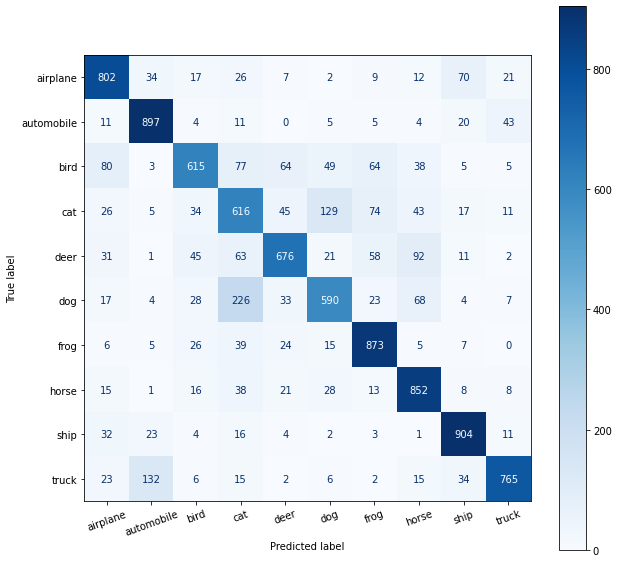

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

Which is the most misunderstood class?

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;
Yes it's cat and dog!


We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

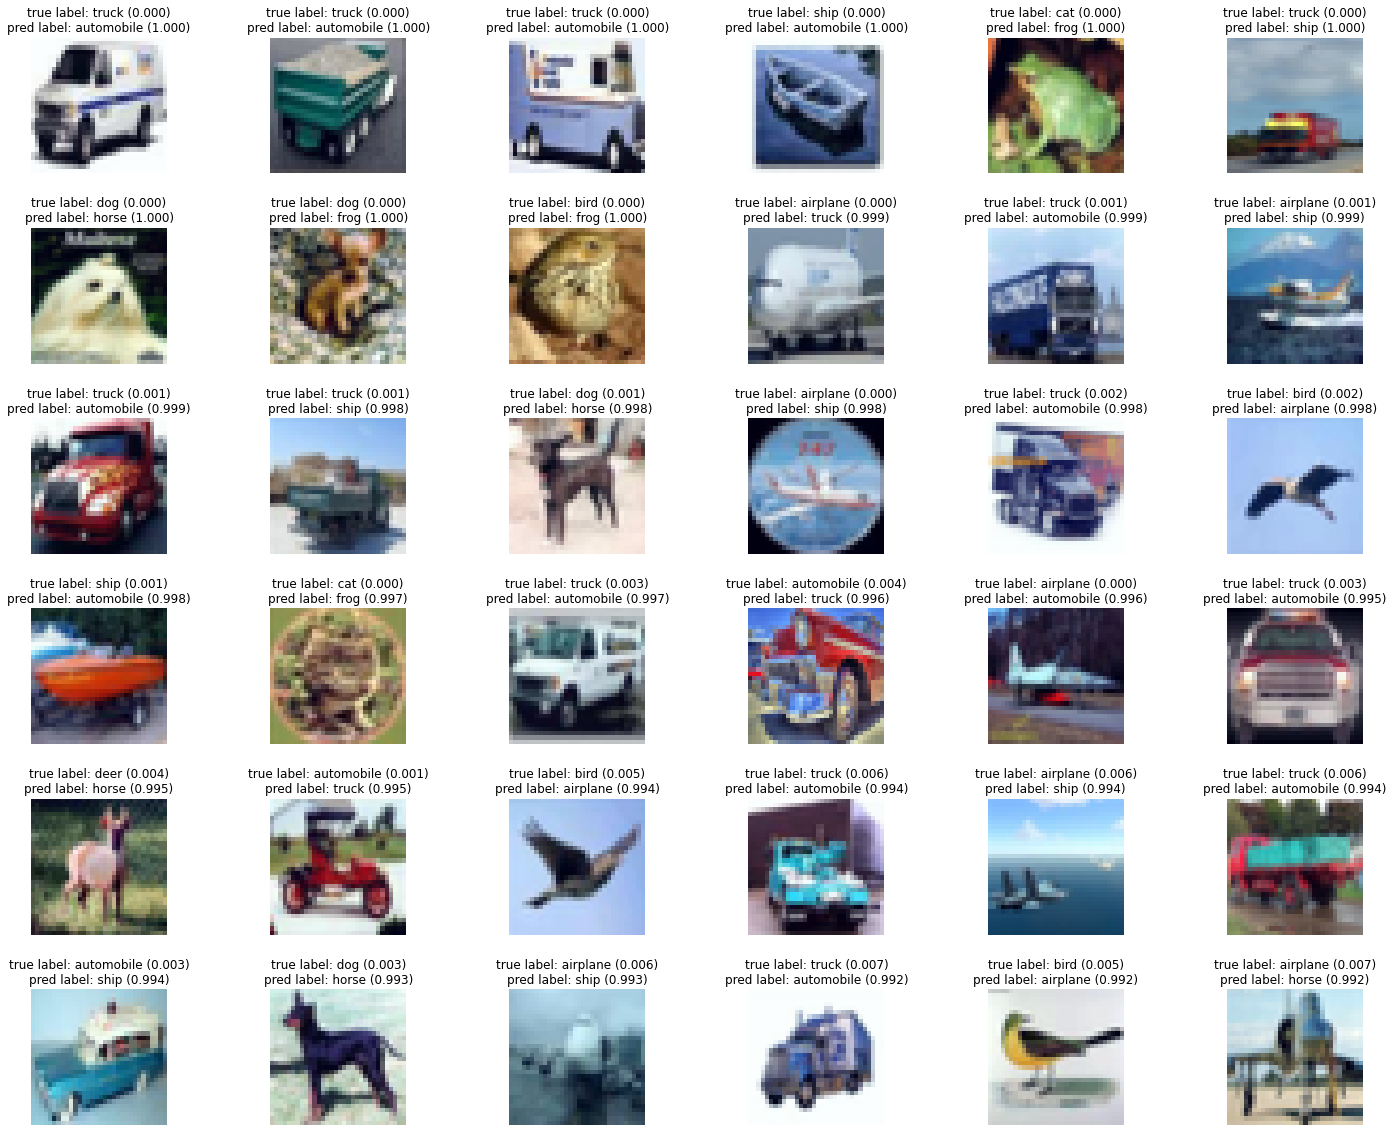

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/176 [00:00<?, ?it/s]

We can then perform PCA

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)


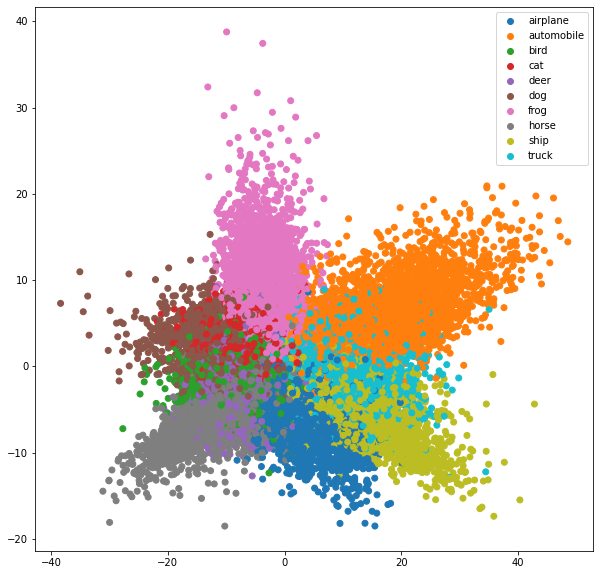

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [ ]:
# --- Play Alone ---
# try to use t-SNE... keep attention on time execution and data size

# Edge Detection

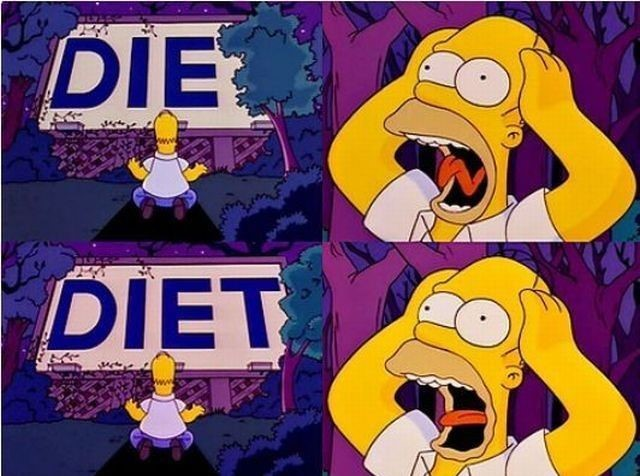

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Read the original image
img = cv2.imread('/content/drive/MyDrive/ML-LAB/Code/ComVis/homer.jpg') 
# Display original image
cv2_imshow(img)

In [ ]:
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

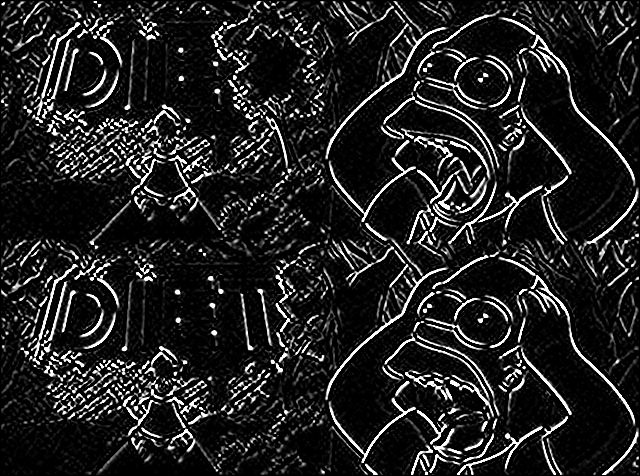

In [ ]:
# Sobel Edge Detection
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
cv2_imshow( sobelxy)


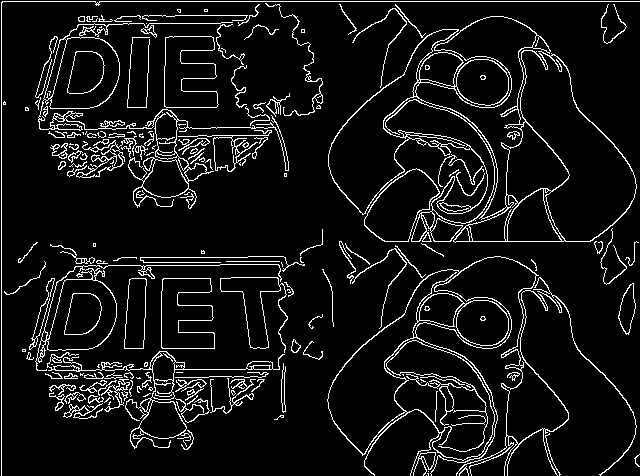

In [ ]:
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) 
cv2_imshow(edges)